### Data Processing, Feature Engineering & Model Building

In this notebook, we shall process our input image data, engineer features to fit the model, build an train the model.

We shall be performing Transfer Learning on an off-the-shelf image classification model called MobileNetV2.

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import pathlib
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import  Dropout, Input
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import *
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
# import tensorflow_datasets as tfds

In [3]:
#Path to data location
data_dir = pathlib.Path('/Users/james/Documents/isw_projects/Image Classifier/Recruitment Data')

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

2148


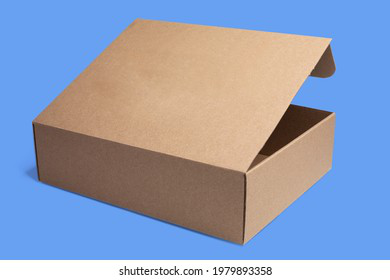

In [5]:
boxes = list(data_dir.glob('*/*'))
PIL.Image.open(str(boxes[0]))

##### Process datasets

In [37]:
# Set some parameters
batch_size = 32
img_height = 160
img_width = 160
IMG_SIZE = (img_height, img_width)

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2148 files belonging to 2 classes.
Using 1719 files for training.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2148 files belonging to 2 classes.
Using 429 files for validation.


In [10]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

In [11]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 12
Number of test batches: 2


In [12]:
class_names = train_ds.class_names
print(class_names)

['Defective Boxes', 'Non Defective Boxes']


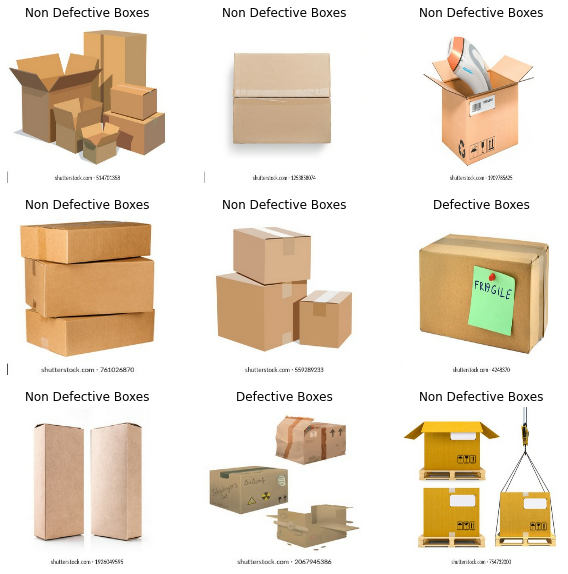

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [14]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 160, 160, 3)
(32,)


##### Configure the dataset for faster performance

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [17]:
# Augment data
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

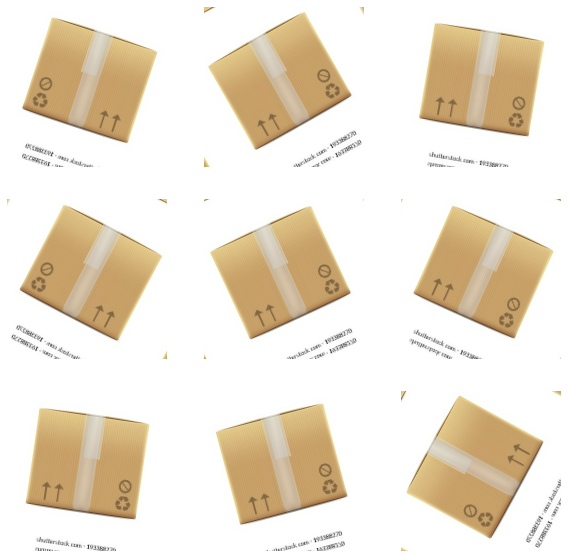

In [18]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

##### Rescale pixel values

In [20]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input


In [21]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)


##### Create Model

Our model architecture will be based on MobileNetV2

In [24]:
mobile_model = tf.keras.applications.mobilenet.MobileNet()

In [28]:
for layer in mobile_model.layers[:-4]:
    layer.trainable = False

In [33]:
# Create the model
model2 = Sequential()
 
# Add the vgg convolutional base model
model2.add(mobile_model)
 
# Add new layers
model2.add(Flatten())
model2.add(Dense(1024, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(2, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 1000)             4253864   
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 1000)              0         
                                                                 
 dense (Dense)               (None, 1024)              1025024   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 2)                 2050      
                                                                 
Total params: 5,280,938
Trainable params: 2,052,074
Non-trainable params: 3,228,864
____________________________________

In [38]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [39]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [40]:
#Feature extraction
#freeze base model and add layers to suit our use case

In [41]:
base_model.trainable = False

In [42]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [43]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [44]:
# Add all layers together
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [45]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [46]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

##### Train Model

In [49]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/10
54/54 [==============================] - 30s 508ms/step - loss: 0.5597 - accuracy: 0.6876 - val_loss: 0.5028 - val_accuracy: 0.7863
Epoch 2/10
54/54 [==============================] - 24s 446ms/step - loss: 0.4849 - accuracy: 0.7760 - val_loss: 0.4459 - val_accuracy: 0.8110
Epoch 3/10
54/54 [==============================] - 24s 451ms/step - loss: 0.4454 - accuracy: 0.8034 - val_loss: 0.4121 - val_accuracy: 0.8301
Epoch 4/10
54/54 [==============================] - 25s 462ms/step - loss: 0.4180 - accuracy: 0.8127 - val_loss: 0.3793 - val_accuracy: 0.8274
Epoch 5/10
54/54 [==============================] - 26s 474ms/step - loss: 0.3996 - accuracy: 0.8214 - val_loss: 0.3729 - val_accuracy: 0.8301
Epoch 6/10
54/54 [==============================] - 27s 502ms/step - loss: 0.3786 - accuracy: 0.8255 - val_loss: 0.3423 - val_accuracy: 0.8438
Epoch 7/10
54/54 [==============================] - 32s 598ms/step - loss: 0.3639 - accuracy: 0.8418 - val_loss: 0.3687 - val_accuracy: 0.8192

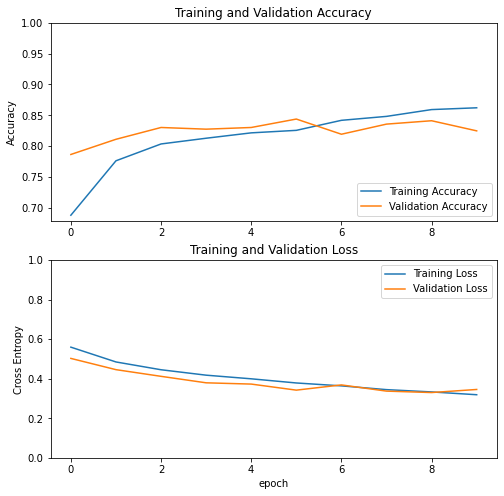

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

##### Fine-tune model

In [52]:
base_model.trainable = True

In [53]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

Number of layers in the base model:  154


In [54]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [56]:
fine_tune_epochs = 15
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 10/25
54/54 [==============================] - 44s 713ms/step - loss: 0.2968 - accuracy: 0.8714 - val_loss: 0.2887 - val_accuracy: 0.8548
Epoch 11/25
54/54 [==============================] - 34s 626ms/step - loss: 0.2505 - accuracy: 0.8970 - val_loss: 0.2521 - val_accuracy: 0.8849
Epoch 12/25
54/54 [==============================] - 35s 645ms/step - loss: 0.2271 - accuracy: 0.9040 - val_loss: 0.2427 - val_accuracy: 0.8932
Epoch 13/25
54/54 [==============================] - 36s 667ms/step - loss: 0.2247 - accuracy: 0.9063 - val_loss: 0.2451 - val_accuracy: 0.8877
Epoch 14/25
54/54 [==============================] - 34s 621ms/step - loss: 0.2032 - accuracy: 0.9139 - val_loss: 0.2624 - val_accuracy: 0.8932
Epoch 15/25
54/54 [==============================] - 39s 712ms/step - loss: 0.1874 - accuracy: 0.9267 - val_loss: 0.2163 - val_accuracy: 0.8877
Epoch 16/25
54/54 [==============================] - 35s 649ms/step - loss: 0.1817 - accuracy: 0.9191 - val_loss: 0.2533 - val_accuracy:

In [57]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

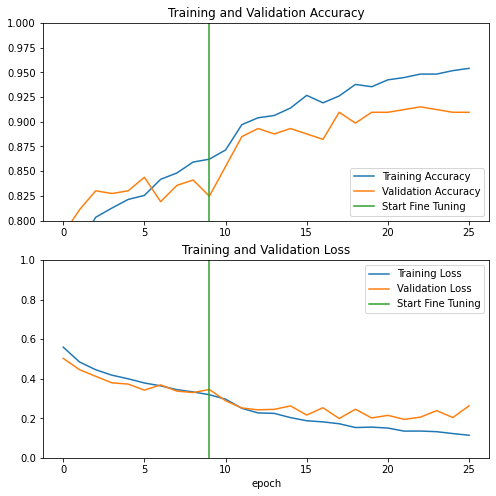

In [58]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

##### Evaluate and predict

In [60]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

2/2 [==============================] - 1s 358ms/step - loss: 0.3087 - accuracy: 0.8594
Test accuracy : 0.859375


Predictions:
 [1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 0]
Labels:
 [1 0 1 1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 0]


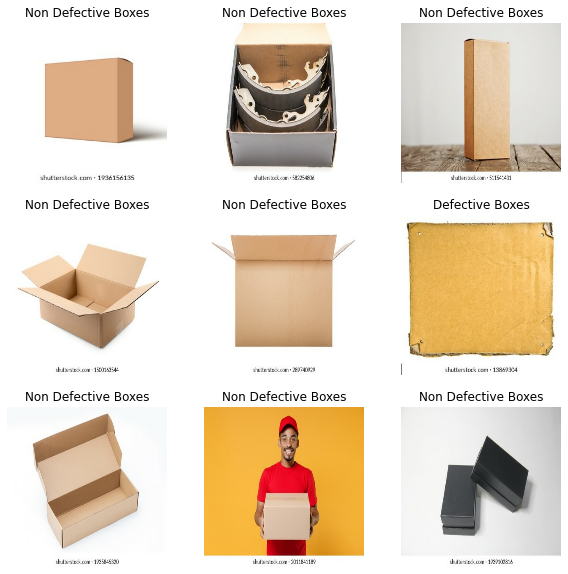

In [61]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

##### # Precision, recall and F1 score

In [62]:
print(classification_report(label_batch, predictions.numpy()))


              precision    recall  f1-score   support

           0       0.83      0.62      0.71         8
           1       0.88      0.96      0.92        24

    accuracy                           0.88        32
   macro avg       0.86      0.79      0.82        32
weighted avg       0.87      0.88      0.87        32



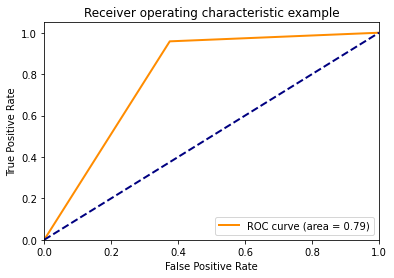

In [63]:
fpr, tpr, _ = roc_curve(label_batch, predictions.numpy())
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

##### Confusion Matrix

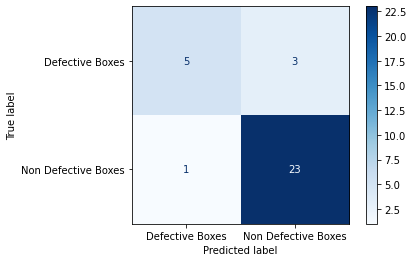

In [65]:
cm = confusion_matrix(label_batch, predictions.numpy())
labels = ['Defective Boxes', 'Non Defective Boxes']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

In [66]:
# Save the entire model to a HDF5 file.
model.save('./models/my_model.h5')

/opt/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
